In [2]:
import pandas as pd
import numpy as np
import itertools
import math
import scipy.stats as st
from sklearn.metrics import r2_score
import seaborn as sns; sns.set_theme(color_codes=False)
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def get_all_params(df):
    """Initializes the variables containing the run names and the parameters dictionary for each run."""
    
    def get_run_params(run):
        result = {}
        params = df[df.type == "param"]
        for index, row in params[params.run == run].iterrows():
            # Convert numerical values to float
            try:
                result[row.attrname] = float(row.attrvalue)
            except ValueError:
                result[row.attrname] = row.attrvalue
        return result
    
    global all_params, all_runs
    
    all_params = {}
    all_runs = df.run.unique()
    for run in all_runs:       
        all_params[run] = get_run_params(run)

In [4]:
def find_runs(params={}):
    """Returns an array containing the run names with the parameters provided as a dictionary."""
    
    if params == {}:
        return all_runs.tolist()
    
    result = []
    
    for run in all_runs:       
        run_params = all_params[run]
        to_keep = True
                
        for name, value in params.items():
            if type(value) is str:
                check_value = '"'+value+'"'
            else:
                check_value = value
                
            if name not in run_params or run_params[name] != check_value:
                to_keep = False
                break
        if to_keep:      
            result.append(run)
                
    return result

In [5]:
def get_vecvalue(run, name):
    """Returns an array containing the values of a given vector for the specified run."""
     
    try:
        return np.fromstring(df[(df.type == "vector") & (df.run == run) & (df.name == name)].iloc[0].vecvalue, 
                             sep=" ", dtype=np.double)
    except Exception:
        return np.array([])


def get_vectime(run, name):
    """Returns an array containing the time values of a given vector for the specified run."""
    
    try:
        return np.fromstring(df[(df.type == "vector") & (df.run == run) & (df.name == name)].iloc[0].vectime, 
                             sep=" ", dtype=np.double)
    except Exception:
        return np.array([])

    
def get_scalar(run, name):
    """Returns the scalar value of the given statistic for the specified run."""
    strvalue = df[(df.type == "scalar") & (df.run == run) & (df.name == name)].iloc[0].value
    try:
        return float(value)
    except Exception:
        return strvalue

In [6]:
def get_throughput(run):
    
    if run is None:
        return None
                          
    return get_vecvalue(run, 'Throughput:vector')


def get_throughput_time(run):
    
    if run is None:
        return None
                          
    return get_vectime(run, 'Throughput:vector')


def get_rt(run):
    
    if run is None:
        return None
                          
    return get_vecvalue(run, 'ResponseTime:vector')


def get_rt_time(run):
    
    if run is None:
        return None
                          
    return get_vectime(run, 'ResponseTime:vector')


def get_num_plane(run):
    
    if run is None:
        return None
                          
    return get_vecvalue(run, 'numPlane:vector')


def get_num_plane_time(run):
    
    if run is None:
        return None
                          
    return get_vectime(run, 'numPlane:vector')


def get_landing_queue(run):
    
    if run is None:
        return None
                          
    return get_vecvalue(run, 'LandingQueueTime:vector')


def get_landing_queue_time(run):
    
    if run is None:
        return None
                          
    return get_vectime(run, 'LandingQueueTime:vector')


def get_takeoff_queue(run):
    
    if run is None:
        return None
                          
    return get_vecvalue(run, 'TakeoffQueueTime:vector')


def get_takeoff_queue_time(run):
    
    if run is None:
        return None
                          
    return get_vectime(run, 'TakeoffQueueTime:vector')


def get_LQ_len(run):
    
    if run is None:
        return None
                          
    return get_vecvalue(run, 'LQ_length:vector')


def get_LQ_len_time(run):
    
    if run is None:
        return None
                          
    return get_vectime(run, 'LQ_length:vector')


def get_TQ_len(run):
    
    if run is None:
        return None
                          
    return get_vecvalue(run, 'TQ_length:vector')


def get_TQ_len_time(run):
    
    if run is None:
        return None
                          
    return get_vectime(run, 'TQ_length:vector')


def get_ROT(run):
    
    if run is None:
        return None

    return get_scalar(run, 'ROT')


def get_landing_occupancy(run):
    
    if run is None:
        return None

    return get_scalar(run, 'rho_l')


def get_takeoff_occupancy(run):
    
    if run is None:
        return None

    return get_scalar(run, 'rho_t')

In [50]:
def predict_waiting_times(iat, tl, tt):
    rho_l = tl/iat
    rho_t = tt/iat
    rt = (tt * iat)/(iat - tt) + rho_l * tl
    wt = rt - tt
    nt = rt / iat
    rl = (tl * iat)/(iat - tl) + nt * rt * 1/(1 - rho_t)
    wl = rl - tl
    return (wl, wt)

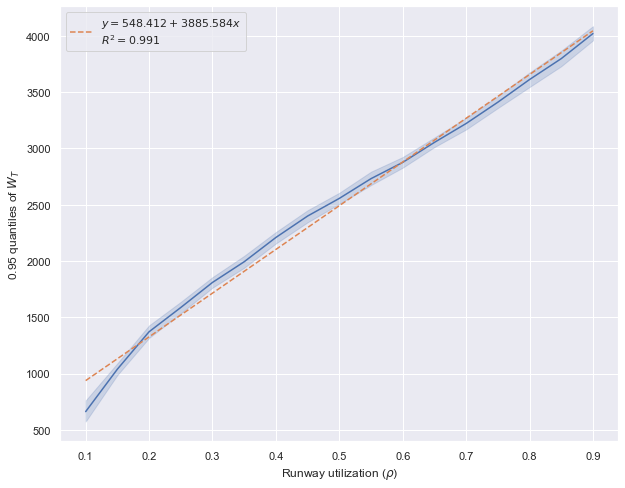

In [7]:
all_params = {}
all_runs = None
df = pd.read_csv('../results/control_tower_queues_1.csv')
get_all_params(df)

iats_to_rho = {
    18000: 0.1,
    12000: 0.15,
    9000: 0.2,
    7200: 0.25,
    6000: 0.3,
    5143: 0.35,
    4500: 0.4,
    4000: 0.45,
    3600: 0.5,
    3273: 0.55,
    3000: 0.6,
    2770: 0.65,
    2571: 0.7,
    2400: 0.75,
    2250: 0.8,
    2118: 0.85,
    2000: 0.9,
}

rhos = sorted(list(iats_to_rho.values()))
rows = []
waits = []
_, ax = plt.subplots(figsize=(10, 8))

for iat, rho in iats_to_rho.items():
    runs = find_runs({'**.interarrivalTimeAvg': float(iat)})
    
    temp = []
    for rep, run in enumerate(runs):
        waits_ = get_takeoff_queue(run)
        #waits_ = waits_[waits_ != 0]
        wait = np.percentile(waits_, 95)
        row = {'rho': rho, 'rep': rep, 'wait': wait}
        rows.append(row)
        temp.append(wait)
    waits.append(np.mean(temp))

data = pd.DataFrame(rows)
sns.lineplot(data=data, x='rho', y='wait', markers=True, dashes=False, ax=ax)
ax.set_xlabel("$\dfrac{{1}}{{\lambda_v}}$")
ax.set_ylabel("$E[W]$")

m, b = np.polyfit(rhos, waits, 1)
waits_predicted = [m * x + b for x in rhos]
r_squared = r2_score(waits, waits_predicted)
ax.plot(rhos, waits_predicted, '--', label="$y = {:.3f}+{:.3f}x $\n$R^2 = {:.3f}$".format(b, m, r_squared))
plt.legend()
plt.xlabel("Runway utilization ($ \\rho $)")
plt.ylabel("0.95 quantiles of $W_T$")
plt.grid(True, 'both')
plt.savefig("../results/plots/rho_wt.pdf")

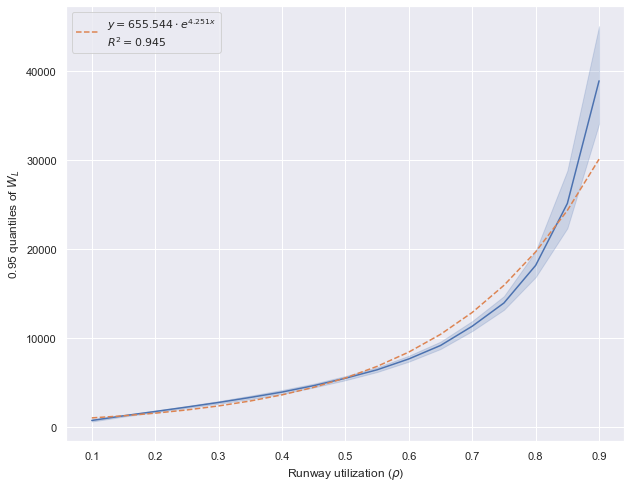

In [8]:
_, ax = plt.subplots(figsize=(10, 8))

rhos = sorted(list(iats_to_rho.values()))
rows = []
waits = []

for iat, rho in iats_to_rho.items():
    runs = find_runs({'**.interarrivalTimeAvg': float(iat)})
    
    temp = []
    for rep, run in enumerate(runs):
        wait = np.percentile(get_landing_queue(run), 95)
        row = {'rho': rho, 'rep': rep, 'wait': wait}
        rows.append(row)
        temp.append(wait)
    waits.append(np.mean(temp))

log_waits = np.log(waits)
m, b = np.polyfit(rhos, log_waits, 1)
waits_predicted = [math.e**(m * x) * math.e**b for x in rhos]
data = pd.DataFrame(rows)
sns.lineplot(data=data, x='rho', y='wait', markers=True, dashes=False, ax=ax)
ax.set_xlabel("$\dfrac{{1}}{{\lambda_v}}$")
ax.set_ylabel("$E[W]$")
r_squared = r2_score(waits, waits_predicted)
ax.plot(rhos, waits_predicted, '--', label="$y = {:.3f} \cdot e^{{{:.3f}x}} $\n$R^2 = {:.3f}$".format(math.e**b, m, r_squared))
plt.legend(loc='upper left')
plt.xlabel("Runway utilization ($ \\rho $)")
plt.ylabel("0.95 quantiles of $W_L$")
plt.grid(True, 'both')
plt.savefig("../results/plots/rho_wl.pdf")

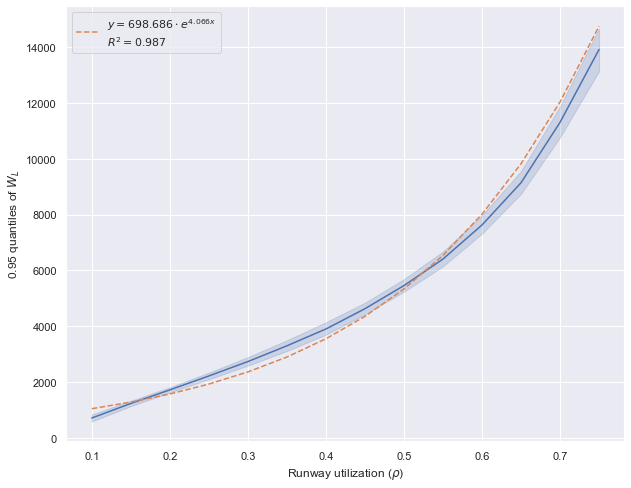

In [9]:
_, ax = plt.subplots(figsize=(10, 8))

iats_to_rho = {
    18000: 0.1,
    12000: 0.15,
    9000: 0.2,
    7200: 0.25,
    6000: 0.3,
    5143: 0.35,
    4500: 0.4,
    4000: 0.45,
    3600: 0.5,
    3273: 0.55,
    3000: 0.6,
    2770: 0.65,
    2571: 0.7,
    2400: 0.75,
    2250: 0.8,
    2118: 0.85,
    2000: 0.9,
}
del iats_to_rho[2250]
del iats_to_rho[2118]
del iats_to_rho[2000]

rhos = sorted(list(iats_to_rho.values()))
rows = []
waits = []

for iat, rho in iats_to_rho.items():
    runs = find_runs({'**.interarrivalTimeAvg': float(iat)})
    
    temp = []
    for rep, run in enumerate(runs):
        wait = np.percentile(get_landing_queue(run), 95)
        row = {'rho': rho, 'rep': rep, 'wait': wait}
        rows.append(row)
        temp.append(wait)
    waits.append(np.mean(temp))

log_waits = np.log(waits)
m, b = np.polyfit(rhos, log_waits, 1)
waits_predicted = [math.e**(m * x) * math.e**b for x in rhos]
data = pd.DataFrame(rows)
sns.lineplot(data=data, x='rho', y='wait', markers=True, dashes=False, ax=ax)
ax.set_xlabel("$\dfrac{{1}}{{\lambda_v}}$")
ax.set_ylabel("$E[W]$")
r_squared = r2_score(waits, waits_predicted)
ax.plot(rhos, waits_predicted, '--', label="$y = {:.3f} \cdot e^{{{:.3f}x}} $\n$R^2 = {:.3f}$".format(math.e**b, m, r_squared))
plt.legend(loc='upper left')
plt.xlabel("Runway utilization ($ \\rho $)")
plt.ylabel("0.95 quantiles of $W_L$")
plt.grid(True, 'both')
plt.savefig("../results/plots/rho_wl2.pdf")

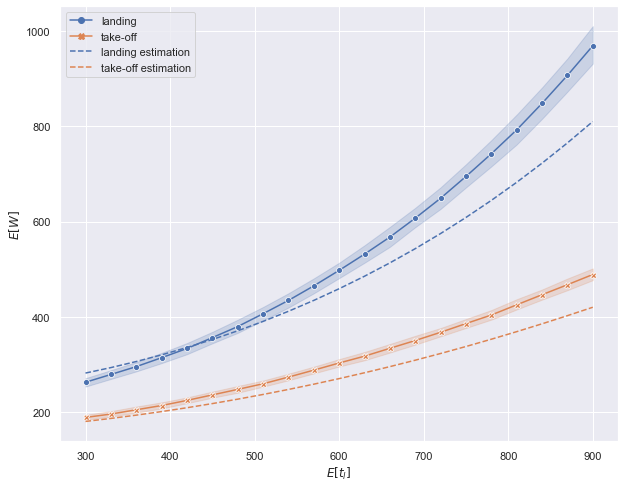

In [49]:
all_params = {}
all_runs = None
df = pd.read_csv('../results/control_tower_queues_9.csv')
get_all_params(df)

lts = range(300, 901, 30)

_, ax = plt.subplots(figsize=(10, 8))
predicted_waits = []

rows = []
for lt in lts:
    runs = find_runs({"**.landingTimeAvg": float(lt)})
    predicted_waits.append(predict_waiting_times(3000, float(lt), 600))
    waits = []
    
    for rep, run in enumerate(runs):
        tq_wait = np.mean(get_takeoff_queue(run))
        lq_wait = np.mean(get_landing_queue(run))
        waits.append(tq_wait)
        row = {'lt': float(lt), 'rep': rep, 'wait': lq_wait, 'queue': 'landing'}
        rows.append(row)
        row = {'lt': float(lt), 'rep': rep, 'wait': tq_wait, 'queue': 'take-off'}
        rows.append(row)

data = pd.DataFrame(rows)
sns.lineplot(data=data, x='lt', y='wait', hue='queue', style='queue', markers=True, dashes=False, ax=ax)
ax.plot(lts, [y[0] for y in predicted_waits], '--', label='landing estimation', color='C0')
ax.plot(lts, [y[1] for y in predicted_waits], '--', label='take-off estimation', color='C1')
ax.legend()
ax.grid(True, 'both')
ax.set_xlabel("$E[t_l]$")
ax.set_ylabel("$E[W]$")
plt.savefig("../results/plots/queues_lt.pdf")

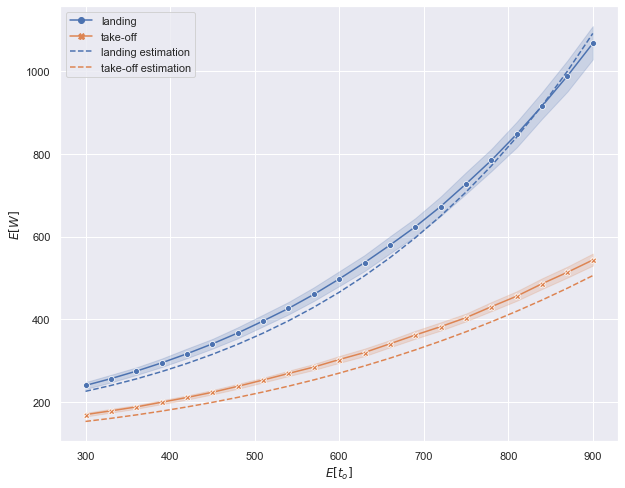

In [11]:
all_params = {}
all_runs = None
df = pd.read_csv('../results/control_tower_queues_10.csv')
get_all_params(df)

tots = range(300, 901, 30)

_, ax = plt.subplots(figsize=(10, 8))
predicted_waits = []

rows = []
for tot in tots:
    runs = find_runs({"**.takeoffTimeAvg": float(tot)})
    predicted_waits.append(predict_waiting_times(3000, 600, float(tot)))
    
    for rep, run in enumerate(runs):
        tq_wait = np.mean(get_takeoff_queue(run))
        lq_wait = np.mean(get_landing_queue(run))
        row = {'tot': float(tot), 'rep': rep, 'wait': lq_wait, 'queue': 'landing'}
        rows.append(row)
        row = {'tot': float(tot), 'rep': rep, 'wait': tq_wait, 'queue': 'take-off'}
        rows.append(row)

data = pd.DataFrame(rows)
sns.lineplot(data=data, x='tot', y='wait', hue='queue', style='queue', markers=True, dashes=False, ax=ax)
ax.plot(tots, [y[0] for y in predicted_waits], '--', label='landing estimation', color='C0')
ax.plot(tots, [y[1] for y in predicted_waits], '--', label='take-off estimation', color='C1')
ax.legend()
ax.grid(True, 'both')
ax.set_xlabel("$E[t_o]$")
ax.set_ylabel("$E[W]$")
plt.savefig("../results/plots/queues_tt.pdf")

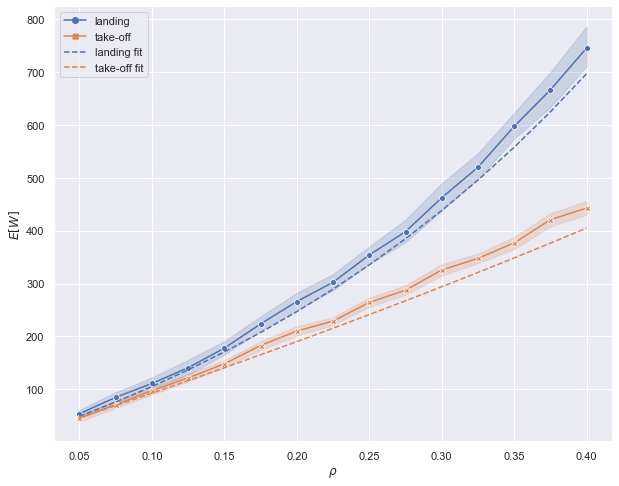

In [12]:
all_params = {}
all_runs = None
df = pd.read_csv('../results/control_tower_queues_11.csv')
get_all_params(df)

iats_to_rho = {
    36000.0: 0.05,
    24000.0: 0.075,
    18000.0: 0.1,
    14400.0: 0.125,
    12000.0: 0.15, 
    10286.0: 0.175,
    9000.0: 0.2,
    8000.0: 0.225,
    7200.0: 0.25,
    6545.0: 0.275,
    6000.0: 0.3,
    5538.0: 0.325,
    5143.0: 0.35,
    4800.0: 0.375,
    4500.0: 0.4,
}
iats = [36000, 24000, 18000, 14400, 12000, 10286, 9000, 8000, 7200, 6545, 6000, 5538, 5143, 4800, 4500]
iats_to_rho = {float(a): 1800/float(a) for a in iats}

rhos = sorted(list(iats_to_rho.values()))

_, ax = plt.subplots(figsize=(10, 8))
predicted_waits = []

rows = []
for iat, rho in iats_to_rho.items():
    runs = find_runs({'**.interarrivalTimeAvg': float(iat)})
    predicted_waits.append(predict_waiting_times(float(iat), 900, 900))
    
    for rep, run in enumerate(runs):
        tq_wait = np.mean(get_takeoff_queue(run))
        lq_wait = np.mean(get_landing_queue(run))
        row = {'rho': rho, 'rep': rep, 'wait': lq_wait, 'queue': 'landing'}
        rows.append(row)
        row = {'rho': rho, 'rep': rep, 'wait': tq_wait, 'queue': 'take-off'}
        rows.append(row)

data = pd.DataFrame(rows)
sns.lineplot(data=data, x='rho', y='wait', hue='queue', style='queue', markers=True, dashes=False, ax=ax)
ax.plot(rhos, [y[0] for y in predicted_waits], '--', label='landing fit', color='C0')
ax.plot(rhos, [y[1] for y in predicted_waits], '--', label='take-off fit', color='C1')
ax.legend()
ax.grid(True, 'both')
ax.set_xlabel("$\\rho$")
ax.set_ylabel("$E[W]$")
plt.savefig("../results/plots/queues_rho11.pdf")

In [13]:
all_params = {}
all_runs = None
df = pd.read_csv('../results/control_tower_queues_rhos1.csv')
get_all_params(df)

iats_to_rho = {
    18000: 0.1,
    12000: 0.15,
    9000: 0.2,
    7200: 0.25,
    6000: 0.3,
    5143: 0.35,
    4500: 0.4,
    4000: 0.45,
    3600: 0.5,
    3273: 0.55,
    3000: 0.6,
    2770: 0.65,
    2571: 0.7,
    2400: 0.75,
    2250: 0.8,
    2118: 0.85,
    2000: 0.9,
}
iats = sorted(list(iats_to_rho.keys()))
rhos = [iats_to_rho[i] for i in iats]

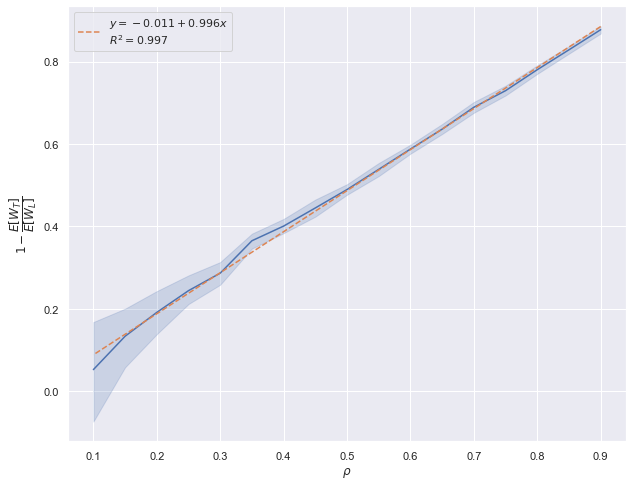

In [14]:
_, ax = plt.subplots(figsize=(10, 8))
predicted_ratios = []

rows = []
advs = []
for iat in iats:
    runs = find_runs({"**.interarrivalTimeAvg": float(iat)})
    rho_t = 900 / float(iat)
    predicted_ratios.append(rho_t)
    
    temp = []
    for rep, run in enumerate(runs):
        l_wait = np.mean(get_landing_queue(run))
        t_wait = np.mean(get_takeoff_queue(run))
        adv = 1 - t_wait/l_wait
        temp.append(adv)
        row = {'$\\rho$': iats_to_rho[iat], 'rep': rep, 'adv': adv}
        rows.append(row)
    advs.append(np.mean(temp))

data = pd.DataFrame(rows)
sns.lineplot(data=data, x='$\\rho$', y='adv', markers=True, dashes=False, ax=ax)
m, b = np.polyfit(rhos, advs, 1)
advs_predicted = [m * x + b for x in rhos]
r_squared = r2_score(advs, advs_predicted)
ax.plot(rhos, advs_predicted, '--', label="$y = {:.3f}+{:.3f}x $\n$R^2 = {:.3f}$".format(b, m, r_squared))
plt.legend()
ax.grid(True, 'both')
ax.set_xlabel("$\\rho$")
ax.set_ylabel("$1 - \dfrac{E[W_T]}{E[W_L]}$")
plt.savefig("../results/plots/rho-adv.pdf")

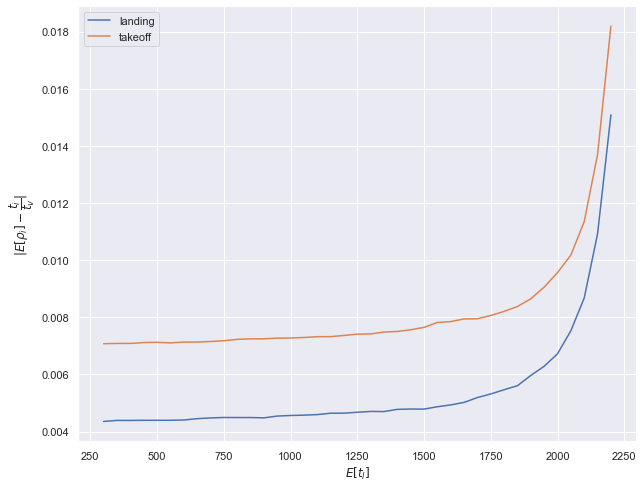

In [46]:
all_params = {}
all_runs = None
df = pd.read_csv('../results/control_tower_queues_19.csv')
get_all_params(df)

lts = range(300, 2201, 50)

_, ax = plt.subplots(figsize=(10, 8))
predicted_waits = []
predicted_waits2 = []

rows = []
ls = []
ts = []
for lt in lts:
    runs = find_runs({"**.landingTimeAvg": float(lt)})
    predicted_waits.append(float(lt)/3000)
    predicted_waits2.append(750/3000)
    
    temp_l = []
    temp_t = []
    for rep, run in enumerate(runs):
        lq_wait = np.mean(get_landing_occupancy(run))
        temp_l.append(lq_wait)
        row = {'lt': float(lt), 'rep': rep, 'wait': -(lq_wait-predicted_waits[-1])/lq_wait, 'queue': 'landing'}
        rows.append(row)
        tq_wait = np.mean(get_takeoff_occupancy(run))
        temp_t.append(tq_wait)
        row = {'lt': float(lt), 'rep': rep, 'wait': -(tq_wait-predicted_waits2[-1])/tq_wait, 'queue': 'takeoff'}
        rows.append(row)
    ls.append(np.mean(temp_l))
    ts.append(np.mean(temp_t))
    
#data = pd.DataFrame(rows)
#sns.lineplot(data=data, x='lt', y='wait', hue='queue', style='queue', markers=True, dashes=False, ax=ax, ci=40)
y_l = [-(x-predicted_waits[i])/x for i, x in enumerate(ls)]
y_t = [-(x-predicted_waits2[i])/x for i, x in enumerate(ts)]
ax.plot(lts, y_l, label="landing")
ax.plot(lts, y_t, label="takeoff")
ax.legend()
ax.grid(True, 'both')
ax.set_xlabel("$E[t_l]$")
ax.set_ylabel("$|E[\\rho_i] - \dfrac{{t_i}}{{t_v}}|$")
plt.savefig("../results/plots/queues_rho_err.pdf")

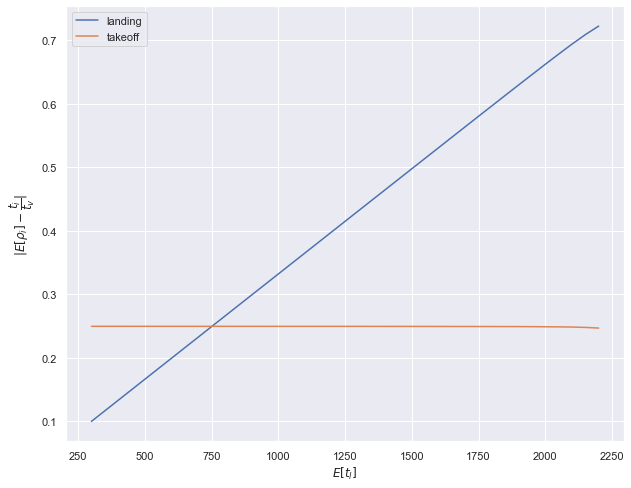

In [52]:
all_params = {}
all_runs = None
df = pd.read_csv('../results/control_tower_queues_21.csv')
get_all_params(df)

lts = range(300, 2201, 50)

_, ax = plt.subplots(figsize=(10, 8))
predicted_waits = []
predicted_waits2 = []

rows = []
ls = []
ts = []
for lt in lts:
    runs = find_runs({"**.landingTimeAvg": float(lt)})
    predicted_waits.append(float(lt)/3000)
    predicted_waits2.append(750/3000)
    
    temp_l = []
    temp_t = []
    for rep, run in enumerate(runs):
        lq_wait = np.mean(get_landing_occupancy(run))
        temp_l.append(lq_wait)
        row = {'lt': float(lt), 'rep': rep, 'wait': lq_wait, 'queue': 'landing'}
        rows.append(row)
        tq_wait = np.mean(get_takeoff_occupancy(run))
        temp_t.append(tq_wait)
        row = {'lt': float(lt), 'rep': rep, 'wait': tq_wait, 'queue': 'takeoff'}
        rows.append(row)
    ls.append(np.mean(temp_l))
    ts.append(np.mean(temp_t))
    
#data = pd.DataFrame(rows)
#sns.lineplot(data=data, x='lt', y='wait', hue='queue', style='queue', markers=True, dashes=False, ax=ax, ci=40)
y_l = [-(x-predicted_waits[i])/x for i, x in enumerate(ls)]
y_t = [-(x-predicted_waits2[i])/x for i, x in enumerate(ts)]
ax.plot(lts, ls, label="landing")
ax.plot(lts, ts, label="takeoff")
ax.legend()
ax.grid(True, 'both')
ax.set_xlabel("$E[t_l]$")
ax.set_ylabel("$|E[\\rho_i] - \dfrac{{t_i}}{{t_v}}|$")
plt.savefig("../results/plots/queues_rho_err.pdf")

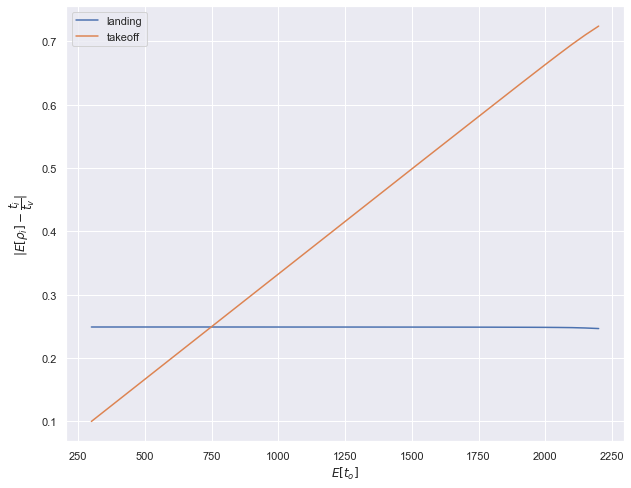

In [53]:
all_params = {}
all_runs = None
df = pd.read_csv('../results/control_tower_queues_20.csv')
get_all_params(df)

lts = range(300, 2201, 50)

_, ax = plt.subplots(figsize=(10, 8))
predicted_waits = []
predicted_waits2 = []

ls = []
ts = []
rows = []
for lt in lts:
    runs = find_runs({"**.takeoffTimeAvg": float(lt)})
    predicted_waits.append(float(lt)/3000)
    predicted_waits2.append(750/3000)
    
    temp_l = []
    temp_t = []
    for rep, run in enumerate(runs):
        tq_wait = np.mean(get_landing_occupancy(run))
        temp_l.append(tq_wait)
        row = {'lt': float(lt), 'rep': rep, 'wait': tq_wait, 'queue': 'landing'}
        rows.append(row)
        lq_wait = np.mean(get_takeoff_occupancy(run))
        temp_t.append(lq_wait)
        row = {'lt': float(lt), 'rep': rep, 'wait': lq_wait, 'queue': 'takeoff'}
        rows.append(row)
    ls.append(np.mean(temp_l))
    ts.append(np.mean(temp_t))

#data = pd.DataFrame(rows)
#sns.lineplot(data=data, x='lt', y='wait', hue='queue', style='queue', markers=True, dashes=False, ax=ax, ci=40)
y_l = [-(x-predicted_waits2[i])/x for i, x in enumerate(ls)]
y_t = [-(x-predicted_waits[i])/x for i, x in enumerate(ts)]
ax.plot(lts, ls, label="landing")
ax.plot(lts, ts, label="takeoff")
ax.legend()
ax.grid(True, 'both')
ax.set_xlabel("$E[t_o]$")
ax.set_ylabel("$|E[\\rho_i] - \dfrac{{t_i}}{{t_v}}|$")
plt.savefig("../results/plots/queues_rho_err2.pdf")